In [1]:
import catboost
import lightgbm as lgb
import os
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import sklearn
import numpy as np
import gc

In [2]:
!7z e /kaggle/input/kkbox-music-recommendation-challenge/members.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C,Utf16=off,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/kkbox-music-recommendation-challenge                                                            1 file, 1349856 bytes (1319 KiB)

Extracting archive: /kaggle/input/kkbox-music-recommendation-challenge/members.csv.7z
--
Path = /kaggle/input/kkbox-music-recommendation-challenge/members.csv.7z
Type = 7z
Physical Size = 1349856
Headers Size = 130
Method = LZMA2:3m
Solid = -
Blocks = 1

    Everything is Ok

Size:       2503827
Compressed: 1349856


In [3]:
!7z e /kaggle/input/kkbox-music-recommendation-challenge/song_extra_info.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C,Utf16=off,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/kkbox-music-recommendation-challenge                                                            1 file, 103608205 bytes (99 MiB)

Extracting archive: /kaggle/input/kkbox-music-recommendation-challenge/song_extra_info.csv.7z
--
Path = /kaggle/input/kkbox-music-recommendation-challenge/song_extra_info.csv.7z
Type = 7z
Physical Size = 103608205
Headers Size = 140
Method = LZMA:25
Solid = -
Blocks = 1

      1% - song_extra_info.c                          4% - song_extra_info.c                          6% - song_extra_info.c                          9% - song_extra_info.c                         11% - song_extra_info.c                         13% - song_extra_info.c                         16% - song_extra_info.c                         18% - song_

In [4]:
!7z e /kaggle/input/kkbox-music-recommendation-challenge/songs.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C,Utf16=off,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/kkbox-music-recommendation-challenge                                                            1 file, 105809525 bytes (101 MiB)

Extracting archive: /kaggle/input/kkbox-music-recommendation-challenge/songs.csv.7z
--
Path = /kaggle/input/kkbox-music-recommendation-challenge/songs.csv.7z
Type = 7z
Physical Size = 105809525
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

      2% - songs.c                5% - songs.c                7% - songs.c               10% - songs.c               13% - songs.c               15% - songs.c               17% - songs.c               20% - songs.c               22% - songs.c               24% - songs.c               27% - songs.c               30% - songs.c               33% - songs.c               3

In [5]:
!7z e /kaggle/input/kkbox-music-recommendation-challenge/train.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C,Utf16=off,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/kkbox-music-recommendation-challenge                                                            1 file, 106420688 bytes (102 MiB)

Extracting archive: /kaggle/input/kkbox-music-recommendation-challenge/train.csv.7z
--
Path = /kaggle/input/kkbox-music-recommendation-challenge/train.csv.7z
Type = 7z
Physical Size = 106420688
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

      1% - train.c                3% - train.c                6% - train.c                7% - train.c                9% - train.c               11% - train.c               13% - train.c               15% - train.c               18% - train.c               20% - train.c               22% - train.c               23% - train.c               25% - train.c               2

In [6]:
!7z e /kaggle/input/kkbox-music-recommendation-challenge/test.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C,Utf16=off,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/kkbox-music-recommendation-challenge                                                            1 file, 43925208 bytes (42 MiB)

Extracting archive: /kaggle/input/kkbox-music-recommendation-challenge/test.csv.7z
--
Path = /kaggle/input/kkbox-music-recommendation-challenge/test.csv.7z
Type = 7z
Physical Size = 43925208
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

      3% - test.cs                8% - test.cs               13% - test.cs               18% - test.cs               21% - test.cs               26% - test.cs               31% - test.cs               36% - test.cs               39% - test.cs               44% - test.cs               49% - test.cs               54% - test.cs               59% - test.cs               63% - 

# Import data

In [7]:
train = pd.read_csv("/kaggle/working/train.csv", dtype={'msno' : 'category',
                                            'source_system_tab' : 'category',
                                            'source_screen_name' : 'category',
                                            'source_type' : 'category',
                                            'target' : np.uint8,
                                            'song_id' : 'category'})

test = pd.read_csv("/kaggle/working/test.csv", dtype={'msno' : 'category',
                                        'source_system_tab' : 'category',
                                        'source_screen_name' : 'category',
                                        'source_type' : 'category',
                                        'song_id' : 'category'},)

train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [8]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [9]:
songs = pd.read_csv("/kaggle/working/songs.csv")
songs_extra = pd.read_csv("/kaggle/working/song_extra_info.csv")
members = pd.read_csv("/kaggle/working/members.csv", parse_dates=["registration_init_time", "expiration_date"])
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [10]:
songs_extra.head() # специально жизнь подпортили этим isrc...

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [11]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13


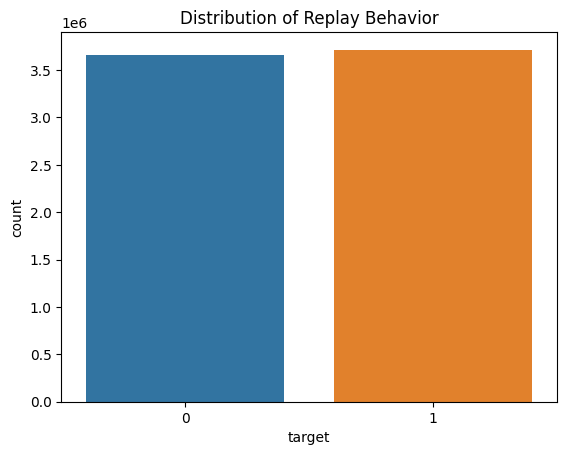

In [12]:
# Target Variable Distribution
plt.figure()
sns.countplot(x="target", data=train)
plt.title("Distribution of Replay Behavior")
plt.show()

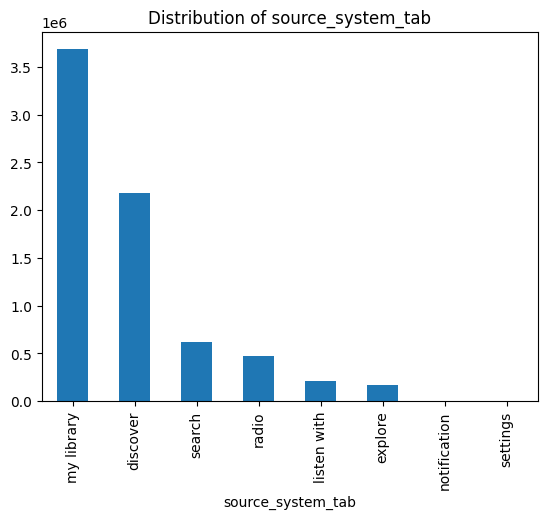

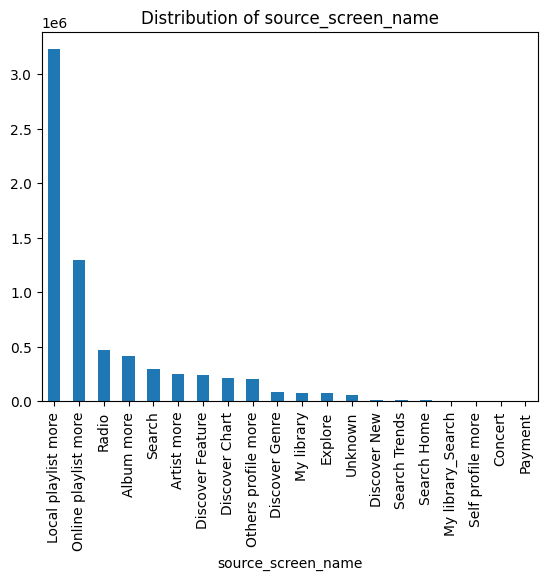

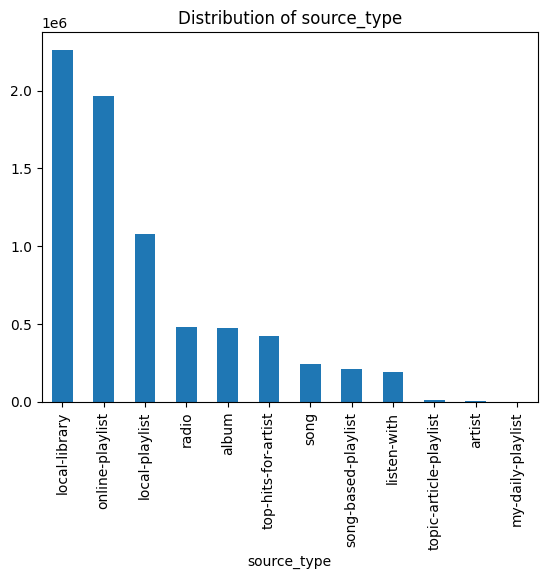

In [13]:
# Analyze Categorical Features
cat_features = ["source_system_tab", "source_screen_name", "source_type"]
for col in cat_features:
    plt.figure()
    train[col].value_counts().plot(kind="bar")
    plt.title(f"Distribution of {col}")
    plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


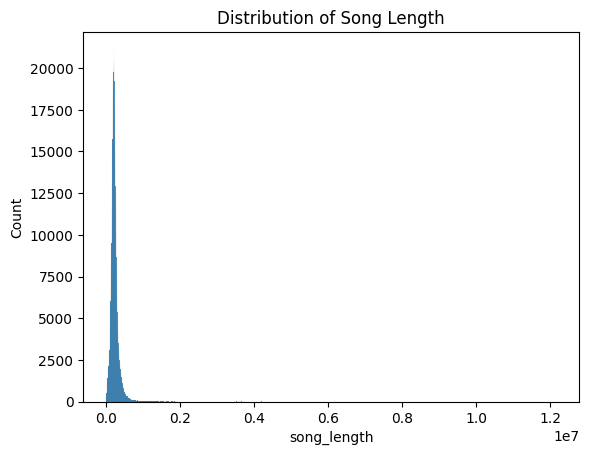

In [14]:
# Analyze Song Lenght
plt.figure()
sns.histplot(x="song_length", data=songs)
plt.title("Distribution of Song Length")
plt.show()

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype   
---  ------              -----   
 0   msno                category
 1   song_id             category
 2   source_system_tab   category
 3   source_screen_name  category
 4   source_type         category
 5   target              uint8   
dtypes: category(5), uint8(1)
memory usage: 82.4 MB


# Problem Statement

$nDCG@20 = \frac{DCG@20}{IDCG@20} \\
DCG@20 = \sum\limits_{k=1}^20 \frac{r^{true}(\pi^{-1}(k))}{\log_2(k+1)} \\
IDCG@20 = \sum\limits_{k=1}^20 = \frac{1}{\log_2(k+1)} \\ $
Т.е. $nDCG@20$ это нормированный Discounted cumulative gain -- релевантный документ в топе приносит некоторую пользу в зависимости от своей релевантности, а $r^{true}(\cdot)$ некая функция релевантности

В данной задаче таргетная метрика $nDCG@20$, но она является кусочно постоянной. Для нее существуют функции потерь, которые напрямую ее оптимизируют, например, LambdaRank или SoftRank (https://research.google/pubs/the-lambdaloss-framework-for-ranking-metric-optimization/). Конкретным подходом является LambdaMART (https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf) -- основанный на градиентном бустинге решающих деревьев. 

Немного потупив, я понял, что таргетом является бинарная метка, а не явная оценка релевантности, поэтому ранжировать элементы так, чтобы релевантные (с меткой 1) оказывались как можно выше в списке из 20 рекомендаций. В такой ситуации можно применить pointwise подход, в нашем случае задача сводится к обучения бинарного классификатора. В такой ситуации, можно взять обычный logloss.

# Prep data

In [16]:
# genre_ids: genre category. Some songs have multiple genres and they are separated by |

songs["genre_ids"] = songs["genre_ids"]
songs["count_genres"] = songs["genre_ids"].apply(lambda x: 0 if x is np.nan else x.count("|") + 1).astype(int)
songs["count_genres"].value_counts() # encode?

count_genres
1    2029328
2     138833
0      94116
3      24064
4       8748
5       1068
6         90
7         62
8         11
Name: count, dtype: int64

In [17]:
# encode genre
genres = songs["genre_ids"].values
encoded = []
for i in genres:
    if i is np.nan:
        encoded.append([0] * 8)
    else:
        encoded.append(list(i.split("|")))
        encoded[-1] += [0] * (8 - len(encoded[-1]))
        
encoded = np.array(encoded)
for i in range(8):
    songs[f"genre_{i}"] = encoded[:, i]
    songs[f"genre_{i}"] =  songs[f"genre_{i}"].astype("category")
    
songs = songs.drop("genre_ids", axis=1)

In [18]:
songs["artist_name"] = songs["artist_name"].fillna("unknown_artist")
songs["artist_name"].value_counts()

artist_name
Various Artists                     145916
証聲音樂圖書館 ECHO MUSIC                   11276
Billy Vaughn                          4828
รวมศิลปิน                             4432
Richard Clayderman                    4180
                                     ...  
Young Riderz                             1
sosui                                    1
The Blinding                             1
Loretta Goggi                            1
Renato pezzella| Renato Pezzella         1
Name: count, Length: 222363, dtype: int64

In [19]:
# songs['lyricist'].value_counts()
songs["lyricist"] = songs["lyricist"].fillna('―') # most popular unknown value

In [20]:
# songs['lyricist'].value_counts()
songs["composer"] = songs["composer"].fillna("unknown_composer")
songs["composer"].value_counts()

composer
unknown_composer                                                  1071358
Neuromancer                                                         17888
Johann Sebastian Bach                                               12105
Wolfgang Amadeus Mozart                                             10839
Marco Rinaldo                                                       10803
                                                                   ...   
Iurii Gennadievich Kaplan                                               1
Mike Jefferson                                                          1
Conor Maynard|Richard Parkhouse|George Tizzard|Camille Purcell          1
Wolfgang Amadeus Mozart / Antonio Vivaldi                               1
Rodney Clawson| Vicky McGehee| David Lee Murphy                         1
Name: count, Length: 329823, dtype: int64

In [21]:
songs["lyricist_count"] = songs["lyricist"].apply(lambda x: 0 if x == "―" else sum(map(x.count, ["/", "|", "||", r"\\", ";", ","])) + 1).astype(int)
songs["composer_count"] = songs["composer"].apply(lambda x: 0 if x == "unknown_composer" else sum(map(x.count, ["/", "|", "||", r"\\", ";", ","])) + 1).astype(int)
songs["artist_count"] = songs["artist_name"].apply(lambda x: 0 if x == "unknown_artist" else sum(map(x.count, [",", "feat", "|", "&", "and"])) + 1).astype(int)
songs["lyricist_count"].value_counts()

lyricist_count
0     1946836
1      238644
2       56733
3       26689
4       13773
5        6808
6        3207
7        1514
8         955
9         485
10        254
11        140
12        107
14         49
13         42
17         18
16         15
18         13
15         13
20         12
19          7
23          2
21          2
25          1
22          1
Name: count, dtype: int64

In [22]:
songs["artist_composer"] = (songs["artist_name"] == songs["composer"]).astype(int).astype("category")
songs["artist_composer_lyricist"] = ((songs["artist_name"] == songs["composer"]) & (songs["composer"] == songs["lyricist"])).astype(int).astype("category")

In [23]:
songs["has_feat"] = songs["artist_name"].apply(lambda x: int("feat" in x)).astype(int).astype("category") # has featured artist

In [24]:
mean_len = songs["song_length"].mean()
print(mean_len)
songs["short_song"] = songs["song_length"].apply(lambda x: int(x < mean_len)).astype(int).astype("category")

246993.49499677744


In [25]:
songs.isna().sum()

song_id                     0
song_length                 0
artist_name                 0
composer                    0
lyricist                    0
language                    1
count_genres                0
genre_0                     0
genre_1                     0
genre_2                     0
genre_3                     0
genre_4                     0
genre_5                     0
genre_6                     0
genre_7                     0
lyricist_count              0
composer_count              0
artist_count                0
artist_composer             0
artist_composer_lyricist    0
has_feat                    0
short_song                  0
dtype: int64

In [26]:
songs["language"] = songs["language"].fillna(0).astype(int).astype("category")

С категориальными фичами как имена композитора пока что сложно что-то придумать. В текущей ситуации A, B, A|B это 3 разных композитора, которые не имеют особой связи. Можно, например, сделать какое-то фиксированное количество распаршенных фичей, как с жанрами: composer_1, ..., composer_n. Пока что хочу попробовать так, как есть.

In [27]:
train.isna().sum()

msno                       0
song_id                    0
source_system_tab      24849
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

In [28]:
train["source_system_tab"] = train["source_system_tab"].astype(str).fillna("unknown_source_system_tab").astype("category")
train["source_screen_name"] = train["source_screen_name"].astype(str).fillna("unknown_source_screen_name").astype("category")
train["source_type"] = train["source_type"].astype(str).fillna("unknown_source_type").astype("category")

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype   
---  ------              -----   
 0   msno                category
 1   song_id             category
 2   source_system_tab   category
 3   source_screen_name  category
 4   source_type         category
 5   target              uint8   
dtypes: category(5), uint8(1)
memory usage: 82.4 MB


In [30]:
train = train.merge(songs, on="song_id", how="left")

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 27 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   msno                      category
 1   song_id                   object  
 2   source_system_tab         category
 3   source_screen_name        category
 4   source_type               category
 5   target                    uint8   
 6   song_length               float64 
 7   artist_name               object  
 8   composer                  object  
 9   lyricist                  object  
 10  language                  category
 11  count_genres              float64 
 12  genre_0                   category
 13  genre_1                   category
 14  genre_2                   category
 15  genre_3                   category
 16  genre_4                   category
 17  genre_5                   category
 18  genre_6                   category
 19  genre_7                   category
 20  ly

In [32]:
# get numerical features from dates
members["reg_day"] = members["registration_init_time"].dt.day
members["reg_month"] = members["registration_init_time"].dt.month
members["reg_year"] = members["registration_init_time"].dt.year

members["exp_day"] = members["expiration_date"].dt.day
members["exp_month"] = members["expiration_date"].dt.month
members["exp_year"] = members["expiration_date"].dt.year

members["subscription_duration"] = (members["expiration_date"] - members["registration_init_time"]).dt.days

members = members.drop(["registration_init_time", "expiration_date"], axis=1) 
gc.collect()
members.head()

,msno,city,bd,gender,registered_via,reg_day,reg_month,reg_year,exp_day,exp_month,exp_year,subscription_duration
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20,8,2011,20,9,2017,2223
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,28,6,2015,22,6,2017,725
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,11,4,2016,12,7,2017,457
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,6,9,2015,7,9,2015,1
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,26,1,2017,13,6,2017,138


Особо много нужной информации из isrc получить нельзя, только год песни, если...

In [33]:
members.isna().sum()

msno                         0
city                         0
bd                           0
gender                   19902
registered_via               0
reg_day                      0
reg_month                    0
reg_year                     0
exp_day                      0
exp_month                    0
exp_year                     0
subscription_duration        0
dtype: int64

In [34]:
members["gender"] = members["gender"].astype(str).fillna("unknown_gender").astype("category")

In [35]:
def get_year_from_isrc(x):
    if type(x) is not str:
        return 0
    if int(x[5:7]) > 17: # year of dataset i guess...
        return 1900 + int(x[5:7])
    else:
        return 2000 + int(x[5:7])


In [36]:
songs_extra["song_year"] = songs_extra["isrc"].apply(get_year_from_isrc).astype(int).astype("category")
songs_extra = songs_extra.drop(["isrc", "name"], axis=1) # strange features
songs_extra.head()

,song_id,song_year
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,2012
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,2016
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,2008
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,2013
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,2013


In [37]:
songs_extra.isna().sum()

song_id      0
song_year    0
dtype: int64

In [38]:
train = train.merge(songs_extra, on="song_id", how="left").merge(members, on="msno", how="left")
gc.collect()
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,artist_name,composer,lyricist,...,bd,gender,registered_via,reg_day,reg_month,reg_year,exp_day,exp_month,exp_year,subscription_duration
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,Bastille,Dan Smith| Mark Crew,―,...,0,nan,7,2,1,2012,5,10,2017,2103
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,Various Artists,unknown_composer,―,...,24,female,9,25,5,2011,11,9,2017,2301
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,―,...,24,female,9,25,5,2011,11,9,2017,2301
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,Soundway,Kwadwo Donkoh,―,...,24,female,9,25,5,2011,11,9,2017,2301
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,Brett Young,Brett Young| Kelly Archer| Justin Ebach,―,...,0,nan,7,2,1,2012,5,10,2017,2103


In [39]:
train = train.dropna() # некоторые данные отвлалились при мердже

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7375849 entries, 0 to 7377417
Data columns (total 39 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   msno                      object  
 1   song_id                   object  
 2   source_system_tab         category
 3   source_screen_name        category
 4   source_type               category
 5   target                    uint8   
 6   song_length               float64 
 7   artist_name               object  
 8   composer                  object  
 9   lyricist                  object  
 10  language                  category
 11  count_genres              float64 
 12  genre_0                   category
 13  genre_1                   category
 14  genre_2                   category
 15  genre_3                   category
 16  genre_4                   category
 17  genre_5                   category
 18  genre_6                   category
 19  genre_7                   category
 20  lyricis

In [41]:
train["lyricist_count"] = train["lyricist_count"].astype(int)
train["composer_count"] = train["composer_count"].astype(int)
train["artist_count"] = train["artist_count"].astype(int)
train["count_genres"] = train["count_genres"].astype(int)

In [42]:
# popularity of the song
songs_played_times = dict(train["song_id"].value_counts())
train["song_played_times"] = train["song_id"].apply(lambda x: songs_played_times.get(x, 0)).astype(int)

In [43]:
train["msno"] = train["msno"].astype("category")
train["song_id"] = train["song_id"].astype("category")
train["artist_name"] = train["artist_name"].astype("category")
train["composer"] = train["composer"].astype("category")
train["lyricist"] = train["lyricist"].astype("category")

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7375849 entries, 0 to 7377417
Data columns (total 40 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   msno                      category
 1   song_id                   category
 2   source_system_tab         category
 3   source_screen_name        category
 4   source_type               category
 5   target                    uint8   
 6   song_length               float64 
 7   artist_name               category
 8   composer                  category
 9   lyricist                  category
 10  language                  category
 11  count_genres              int64   
 12  genre_0                   category
 13  genre_1                   category
 14  genre_2                   category
 15  genre_3                   category
 16  genre_4                   category
 17  genre_5                   category
 18  genre_6                   category
 19  genre_7                   category
 20  lyricis

In [45]:
train.to_csv("train_dataset.csv")

Вообще, в таблице большое количество категориальных признаков. Если решать задачу нейросетевыми методами, то их стоит декодировать с помощью Mean Encoding'a, например.

Бустинг над решающими деревьями можно делать, не используя кодирование категориальных признаков и NaN. Чтобы не быть голословным в выборе модели, хочу добавить, что я недавно был на дне стажера в Яндексе, где рассказывали про построение рекомендаций в Яндекс Музыке. Для одного из первых этапов ранжирования использовали катбуст. Так что это достаточно рабочий метод, хоть и в условиях компании, скорее всего, больше смотрят на бизнес метрики

# Training

В качестве фреймворка для бустинга я выбрал все же LGBM, он в среднем показывает лучшие результаты на этой задаче, это подтверждается лидербордом соревнования, так же я нашел некую сравнительную статистику разных бустингов:
https://cs229.stanford.edu/proj2019spr/report/4.pdf

In [46]:
# train = pd.read_csv("train_datset.csv")

In [47]:
from sklearn.model_selection import train_test_split

X = train.drop(["target"], axis=1)
y = train["target"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=0.01)

In [48]:
# train_data = lgb.Dataset(X_train, y_train)
# test_data = lgb.Dataset(X_test, y_test)
# val_data = lgb.Dataset(X_val, y_val, reference=train_data)

In [49]:
X_train.shape, X_val.shape

((6571881, 39), (66383, 39))

In [50]:
classifier = lgb.LGBMClassifier(
            objective="binary",
            boosting_type= "gbdt",
            n_estimators= 300,
            metric="binary_logloss",
            num_leaves= 150,
            learning_rate= 0.1,
            max_depth= 10,
            reg_alpha=0.1,
            reg_lambda=0.1,
            early_stopping_round=5,
            verbose=True
        )

In [51]:
# model = classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3309250, number of negative: 3262631
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.242198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44464
[LightGBM] [Info] Number of data points in the train set: 6571881, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503547 -> initscore=0.014188
[LightGBM] [Info] Start training from score 0.014188


In [52]:
# model.best_score_ # :(

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('binary_logloss', 0.5509011964259896)]),
             'valid_1': OrderedDict([('binary_logloss', 0.5608945297911657)])})

теперь обучим модель используя катбуст

In [63]:
cat_features = X_train.select_dtypes(["category"]).columns.values
print(cat_features)

['msno' 'song_id' 'source_system_tab' 'source_screen_name' 'source_type'
 'artist_name' 'composer' 'lyricist' 'language' 'genre_0' 'genre_1'
 'genre_2' 'genre_3' 'genre_4' 'genre_5' 'genre_6' 'genre_7'
 'artist_composer' 'artist_composer_lyricist' 'has_feat' 'short_song'
 'song_year' 'gender']


In [64]:
X_train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'song_length', 'artist_name', 'composer', 'lyricist',
       'language', 'count_genres', 'genre_0', 'genre_1', 'genre_2', 'genre_3',
       'genre_4', 'genre_5', 'genre_6', 'genre_7', 'lyricist_count',
       'composer_count', 'artist_count', 'artist_composer',
       'artist_composer_lyricist', 'has_feat', 'short_song', 'song_year',
       'city', 'bd', 'gender', 'registered_via', 'reg_day', 'reg_month',
       'reg_year', 'exp_day', 'exp_month', 'exp_year', 'subscription_duration',
       'song_played_times'],
      dtype='object')

In [72]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=200,
    loss_function='CrossEntropy',
    random_seed=42,
#     task_type="cuda",
    cat_features=cat_features, 
)

In [73]:
x_CB = X_train[:3_000_000] # чтобы не ждать катбуст до утра
y_CB = y_train[:3_000_000]

In [74]:
model.fit(
    x_CB, y_CB,
    # text_features=text_features,
    cat_features=cat_features, 
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=5,
    )

0:	learn: 0.6857776	test: 0.6851945	best: 0.6851945 (0)	total: 8.57s	remaining: 28m 24s
1:	learn: 0.6788708	test: 0.6777178	best: 0.6777178 (1)	total: 16.6s	remaining: 27m 26s
2:	learn: 0.6723212	test: 0.6707489	best: 0.6707489 (2)	total: 24.2s	remaining: 26m 32s
3:	learn: 0.6662640	test: 0.6641564	best: 0.6641564 (3)	total: 32.1s	remaining: 26m 13s
4:	learn: 0.6606193	test: 0.6580278	best: 0.6580278 (4)	total: 40.2s	remaining: 26m 7s
5:	learn: 0.6553922	test: 0.6523167	best: 0.6523167 (5)	total: 48s	remaining: 25m 51s
6:	learn: 0.6503402	test: 0.6468726	best: 0.6468726 (6)	total: 55.7s	remaining: 25m 34s
7:	learn: 0.6452877	test: 0.6411659	best: 0.6411659 (7)	total: 1m 6s	remaining: 26m 33s
8:	learn: 0.6404896	test: 0.6356108	best: 0.6356108 (8)	total: 1m 15s	remaining: 26m 47s
9:	learn: 0.6359004	test: 0.6306844	best: 0.6306844 (9)	total: 1m 25s	remaining: 27m 10s
10:	learn: 0.6314948	test: 0.6256488	best: 0.6256488 (10)	total: 1m 35s	remaining: 27m 25s
11:	learn: 0.6275136	test: 0.6

In [75]:
model.save_model("recsys_entropy_loss.cbm")

In [76]:
from sklearn.metrics import ndcg_score

In [95]:
y_pred = model.predict(X_test)

In [97]:
score = ndcg_score(y_test.reshape(1, -1), y_pred.reshape(1, -1), k=20)
print(f"Catoost model score: NDCG@20: {score}")

Catoost model score: NDCG@20: 0.7501482126357281


# Итоги
Лучший скор на тесте:
```
Catoost model score: NDCG@20: 0.7501482126357281
```

Для более построения более продвинутых RecSys моделей существуют специальные фреймворки (например, surprise). Если бы я участвовал этом в хакатоне, я бы обучил еще пару моделей и усреднил предсказания ($\sigma(\frac{model_1(X) + model_2(X)}{2})$), такой своеобразный беггинг часто помогает на практике. 